In [52]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [53]:
# Import Libraries
import os
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



In [54]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import re
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

In [55]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

In [56]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, GRU, RNN, Dense, Dropout, Bidirectional, SimpleRNN, SpatialDropout1D
from transformers import BertTokenizer, TFBertModel
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from imblearn.over_sampling import RandomOverSampler

# **Data Preprocessing**

In [57]:
# Load the Dataset
df = pd.read_csv('/content/drive/MyDrive/fake_job_postings.csv')

In [58]:
# Shape of the Dataset
df.shape

(17880, 18)

In [59]:
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [60]:
# Removing any leading, and trailing whitespaces in columns
df.columns = df.columns.str.strip()

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15184 non-null  object
 8   benefits             10668 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

In [62]:
# Count the number of columns with dtype 'object'
object_cols = df.select_dtypes(include=['object']).columns
num_object_cols = len(object_cols)

# Count the number of columns with dtype 'int64'
int_cols = df.select_dtypes(include=['int64']).columns
num_int_cols = len(int_cols)

print(f"Object column: {num_object_cols}")
print(f"int64 col: {num_int_cols}")

Object column: 13
int64 col: 5


> Majority of features is Categorical Features

**Dealing with Missing Values**

In [63]:
# Check for missing values
print('Null Values in Each Column:\n')
print(df.isnull().sum())

Null Values in Each Column:

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2696
benefits                7212
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64


In [64]:
# Null values percent
print(df.isnull().mean() * 100)

job_id                  0.000000
title                   0.000000
location                1.935123
department             64.580537
salary_range           83.959732
company_profile        18.501119
description             0.005593
requirements           15.078300
benefits               40.335570
telecommuting           0.000000
has_company_logo        0.000000
has_questions           0.000000
employment_type        19.412752
required_experience    39.429530
required_education     45.329978
industry               27.421700
function               36.101790
fraudulent              0.000000
dtype: float64


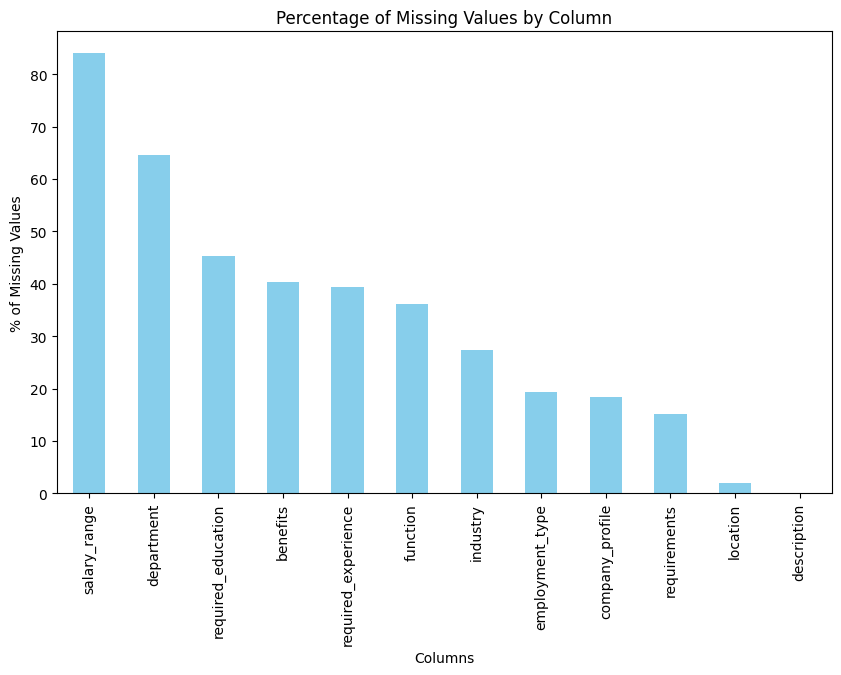

In [65]:
# Count and display percentage of missing values
missing_percent = (df.isnull().sum() / len(df)) * 100
missing_percent = missing_percent[missing_percent > 0].sort_values(ascending=False)

plt.figure(figsize=(10, 6))
missing_percent.plot(kind='bar', color='skyblue')
plt.title('Percentage of Missing Values by Column')
plt.ylabel('% of Missing Values')
plt.xlabel('Columns')
plt.show()

In [66]:
# For text columns, replace missing values with Missing
text_columns = ['title', 'company_profile', 'description', 'requirements', 'benefits']
df[text_columns] = df[text_columns].fillna('Missing')

In [67]:
# For other categorical columns, replace missing values with relevant placeholders
df['location'].fillna('Unknown', inplace=True)
df['department'].fillna('Unknown', inplace=True)
df['salary_range'].fillna('Not Specified', inplace=True)
df['employment_type'].fillna('Not Specified', inplace=True)
df['required_experience'].fillna('Not Specified', inplace=True)
df['required_education'].fillna('Not Specified', inplace=True)
df['industry'].fillna('Not Specified', inplace=True)
df['function'].fillna('Not Specified', inplace=True)

**Some Visualizations**

In [68]:
print("Fraudulent Value Counts:")
print(df['fraudulent'].value_counts())

Fraudulent Value Counts:
fraudulent
0    17014
1      866
Name: count, dtype: int64


In [69]:
# Calculate the total number of job postings
total_postings = len(df)

# Calculate the number of fraudulent postings
fraudulent_postings = df['fraudulent'].value_counts().get(1, 0)

# Calculate the percentage of fraudulent postings
fraud_percentage = (fraudulent_postings / total_postings) * 100

print(f'Total Job Postings: {total_postings}')
print(f'Number of Fraudulent Postings: {fraudulent_postings}')
print(f'Percentage of Fraudulent Postings: {fraud_percentage:.2f}%')

Total Job Postings: 17880
Number of Fraudulent Postings: 866
Percentage of Fraudulent Postings: 4.84%


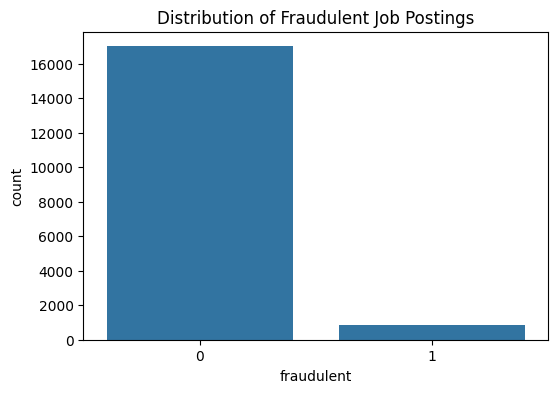

In [70]:
# Bar plot for fraudulent (target) feature
plt.figure(figsize=(6, 4))
sns.countplot(x='fraudulent', data=df)
plt.title('Distribution of Fraudulent Job Postings')
plt.show()

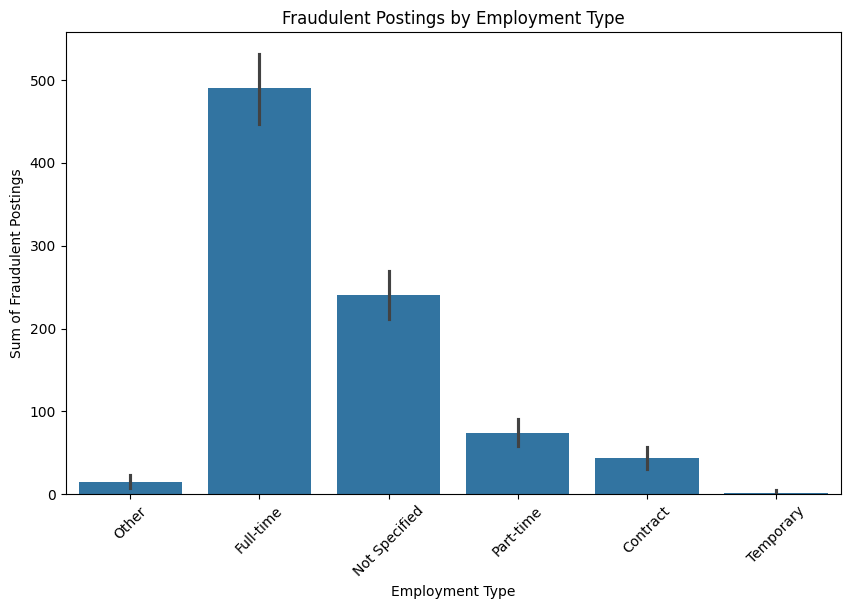

In [71]:
# Bar plot for employment_type
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='employment_type', y='fraudulent', estimator=sum)
plt.title('Fraudulent Postings by Employment Type')
plt.xlabel('Employment Type')
plt.ylabel('Sum of Fraudulent Postings')
plt.xticks(rotation=45)
plt.show()

> Most jobs with fraud are the full time jobs, the least are with Temporary employment

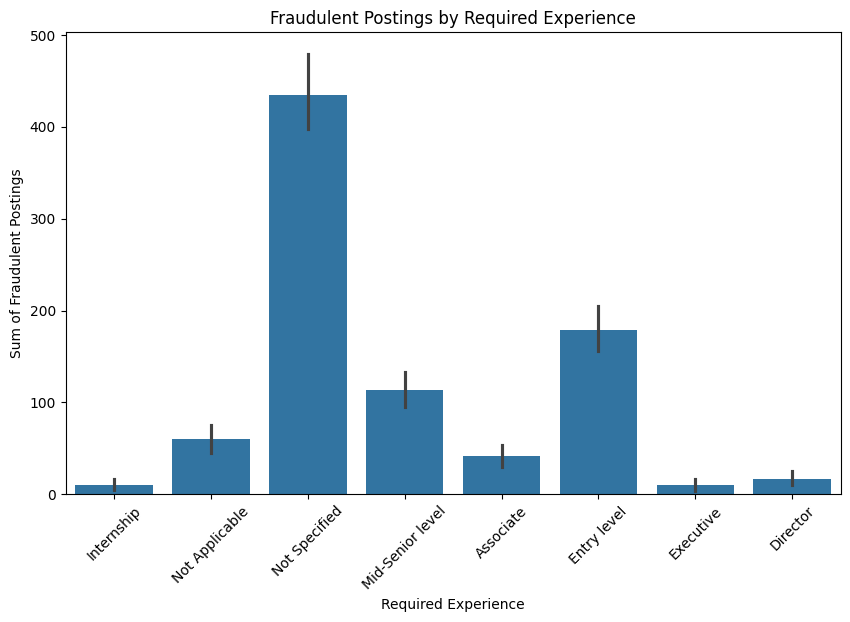

In [72]:
# Bar plot for required_experience
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='required_experience', y='fraudulent', estimator=sum)
plt.title('Fraudulent Postings by Required Experience')
plt.xlabel('Required Experience')
plt.ylabel('Sum of Fraudulent Postings')
plt.xticks(rotation=45)
plt.show()

> Most jobs with fraud are Not Specified in the Required Experience, the least are with Executive and Internship Required Experience

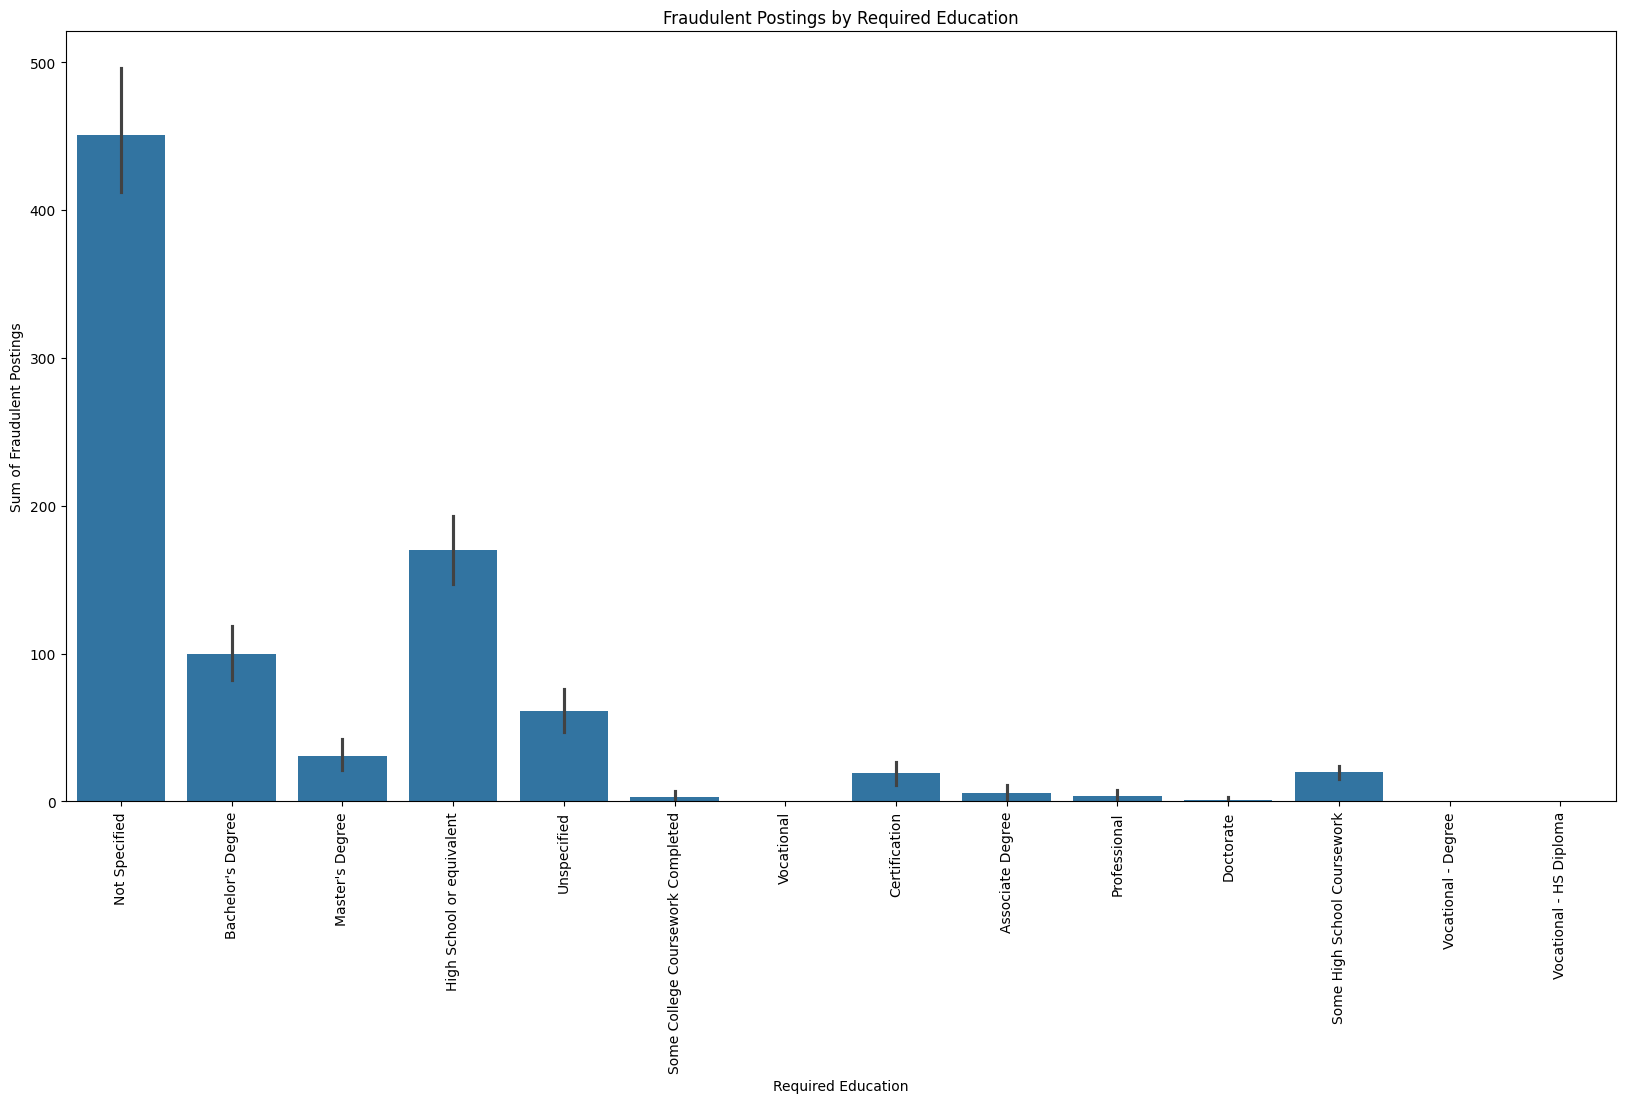

In [73]:
# Bar plot for required_education
plt.figure(figsize=(20, 10))
sns.barplot(data=df, x='required_education', y='fraudulent', estimator=sum)
plt.title('Fraudulent Postings by Required Education')
plt.xlabel('Required Education')
plt.ylabel('Sum of Fraudulent Postings')
plt.xticks(rotation = 90)
plt.show()

> Not Specified Education is the most that have the posibility of fraud Jop Application, Degrees of vocational or has a degree of Doctorate have the least possibility for being fraud

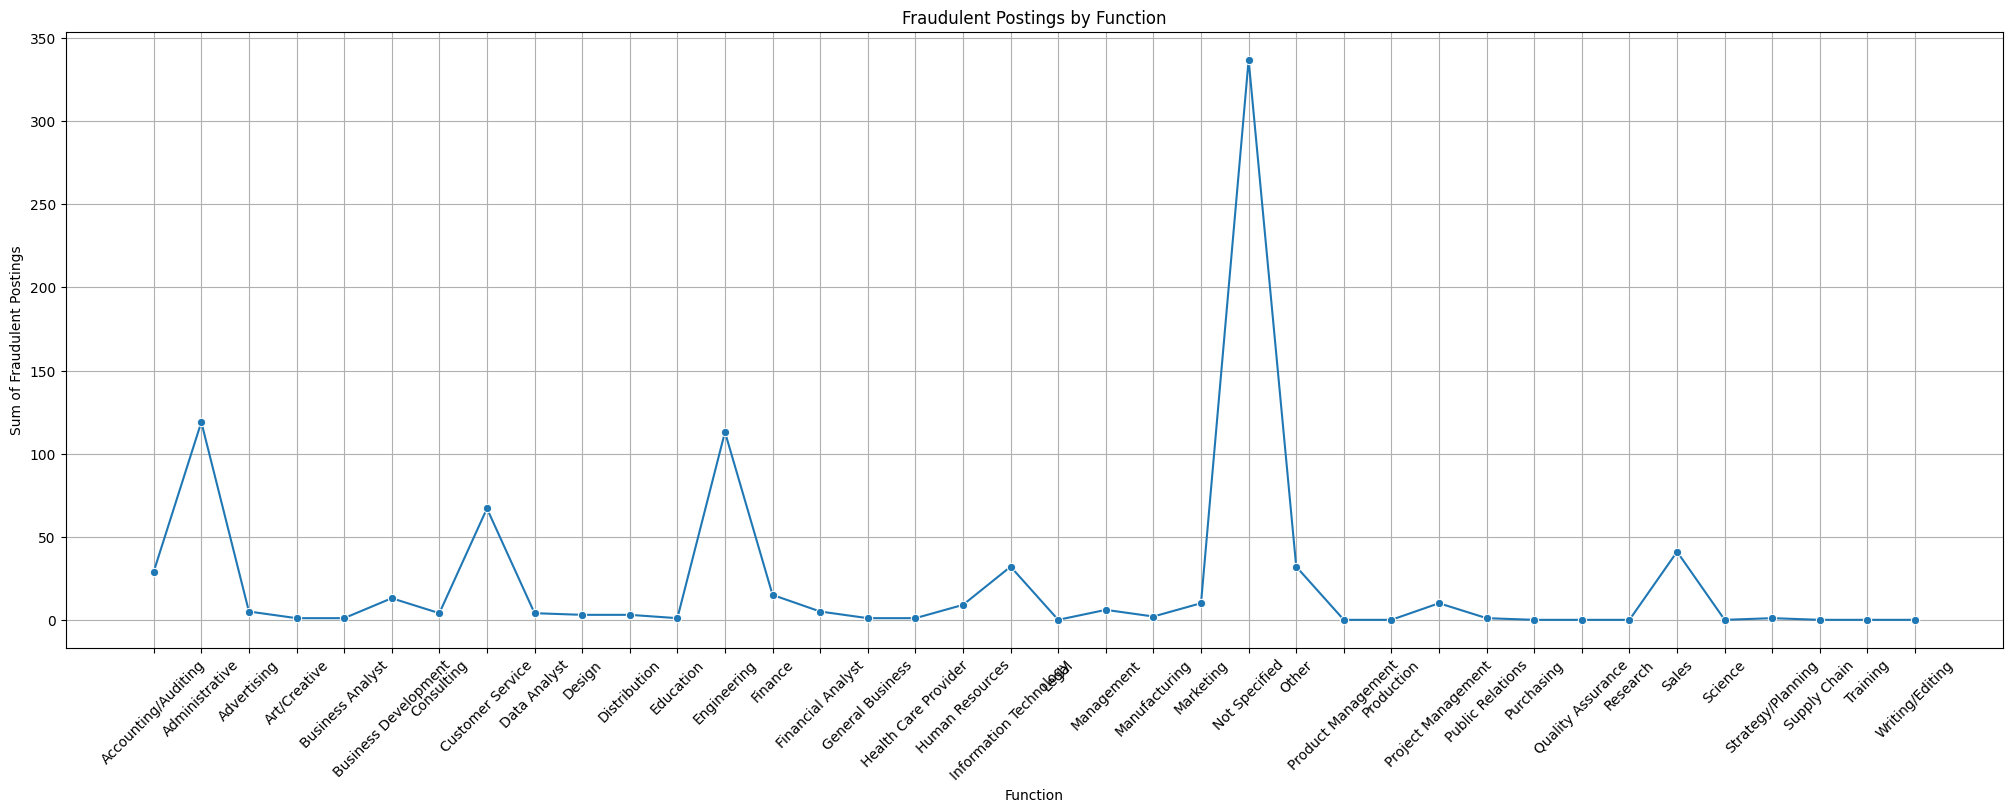

In [74]:
# Calculate the sum of fraudulent postings by function
fraudulent_summary = df.groupby('function')['fraudulent'].sum().reset_index()

plt.figure(figsize=(25, 8))
sns.lineplot(data=fraudulent_summary, x='function', y='fraudulent', marker='o')
plt.title('Fraudulent Postings by Function')
plt.xlabel('Function')
plt.ylabel('Sum of Fraudulent Postings')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

> The most Fraud Job Application aren't Specified its Function, the Marketing Sector/ Field have the least opportunity to be Fraud

# **Text preprocessing**

In [75]:
# Text Preprocessing Function
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = re.sub(r'[^\w\s]', ' ', text)  # Remove punctuation
    return text

In [76]:
# Apply preprocessing to relevant text columns
text_columns = ['title', 'company_profile', 'description', 'requirements', 'benefits']
for col in text_columns:
    df[col] = df[col].apply(preprocess_text)

# **MODELLING**

In [77]:
# Combine Text Features
df['combined_text'] = df[text_columns].agg(' '.join, axis=1)

In [78]:
# Vectorization
# Using TF-IDF for text vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

In [79]:
# Train-Test Split
X = df['combined_text']  # Feature set
y = df['fraudulent']  # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [80]:
# Fit the vectorizer on training data and transform
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [81]:
import pickle
# Save the fitted vectorizer
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)

In [82]:
# Resampling: Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train_tfidf, y_train)

In [83]:
# Check the new class distribution after SMOTE
smote_class_distribution = pd.Series(y_smote).value_counts(normalize=True)
print("New Class Distribution after SMOTE:\n", smote_class_distribution)

New Class Distribution after SMOTE:
 fraudulent
0    0.5
1    0.5
Name: proportion, dtype: float64


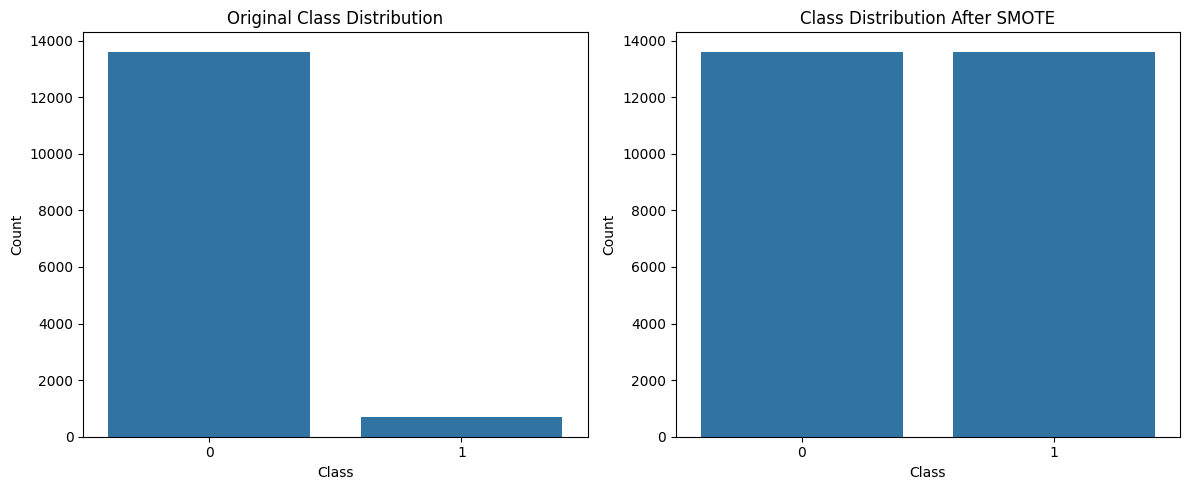

In [84]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.countplot(x=y_train)
plt.title('Original Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sns.countplot(x=y_smote)
plt.title('Class Distribution After SMOTE')
plt.xlabel('Class')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

### **Random Forest**

In [85]:
# Model Selection and Training
model = RandomForestClassifier(random_state=42)
model.fit(X_smote, y_smote)

RandomForestClassifier(random_state=42)

In [86]:
# Evaluation
y_pred = model.predict(X_test_tfidf)

In [87]:
# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      3403
           1       0.99      0.65      0.79       173

    accuracy                           0.98      3576
   macro avg       0.99      0.83      0.89      3576
weighted avg       0.98      0.98      0.98      3576



In [88]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[3402    1]
 [  60  113]]


In [89]:
import pickle

# create an iterator object with write permission - model.pkl
with open('model_pkl', 'wb') as files:
    pickle.dump(model, files)

## **LSTM MODEL**


In [90]:
# Encode the target variable
le = LabelEncoder()
df['fraudulent'] = le.fit_transform(df['fraudulent'])

In [91]:
# Random Oversampling
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train.values.reshape(-1, 1), y_train)

In [92]:
X_resampled = np.array([preprocess_text(text[0]) for text in X_resampled])

In [93]:
# Tokenization and Padding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_length = 100  # Set the maximum length for padding
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_resampled)  # Ensure X_resampled is defined
X_sequences = tokenizer.texts_to_sequences(X_resampled)
X_padded = pad_sequences(X_sequences, maxlen=max_length)

In [94]:
# LSTM Model
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=5000, output_dim=128, input_length=max_length))
lstm_model.add(LSTM(150, return_sequences=True))
lstm_model.add(Dropout(0.5))
lstm_model.add(LSTM(100))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(1, activation='sigmoid'))  # Binary classification
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Training LSTM Model with Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-5)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

lstm_model.fit(X_padded, y_resampled, epochs=20, batch_size=32, validation_split=0.1,
               callbacks=[early_stopping, reduce_lr, model_checkpoint])


Epoch 1/20
766/766 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - accuracy: 0.8877 - loss: 0.2482 - val_accuracy: 0.9963 - val_loss: 0.0165 - learning_rate: 0.0010
Epoch 2/20
766/766 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.9927 - loss: 0.0265 - val_accuracy: 0.9956 - val_loss: 0.0418 - learning_rate: 0.0010
Epoch 3/20
766/766 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.9952 - loss: 0.0167 - val_accuracy: 1.0000 - val_loss: 0.0041 - learning_rate: 0.0010
Epoch 4/20
766/766 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.9971 - loss: 0.0093 - val_accuracy: 1.0000 - val_loss: 0.0022 - learning_rate: 0.0010
Epoch 5/20
766/766 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.9945 - loss: 0.0172 - val_accuracy: 1.0000 - val_loss: 0.0010 - learning_rate: 0.0010
Epoch 6/20
766/766 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - accuracy: 0.9978 - loss: 0.0056 - val_accuracy: 0.9974 - val_loss: 0.0139 - learning_rate: 0.0010
Epoch 7/20
766/766 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9973 - l

In [95]:
# Prepare Test Data for Prediction
X_test_sequences = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_length)

In [96]:
# Evaluate Model
y_pred = lstm_model.predict(X_test_padded)
y_pred_classes = (y_pred > 0.5).astype(int)

112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [97]:
# Classification Report
print("LSTM Classification Report:\n", classification_report(y_test, y_pred_classes))

LSTM Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      3403
           1       0.89      0.63      0.74       173

    accuracy                           0.98      3576
   macro avg       0.93      0.81      0.86      3576
weighted avg       0.98      0.98      0.98      3576



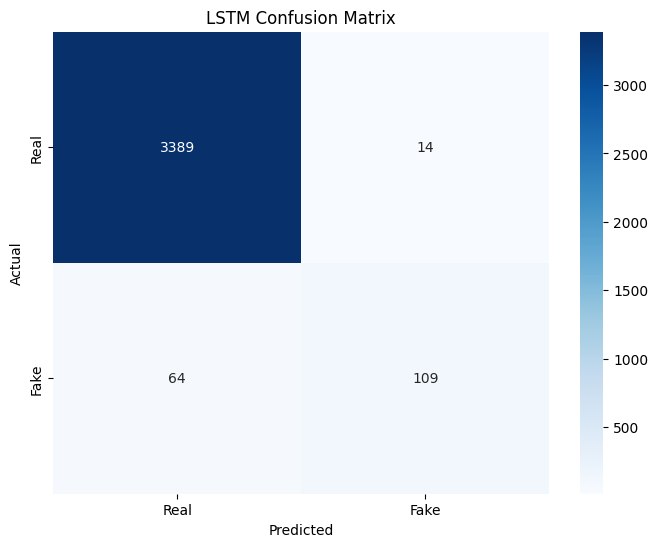

In [98]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title('LSTM Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### **RNN**

In [99]:
# Building RNN Model
rnn_model = Sequential()
rnn_model.add(Embedding(input_dim=5000, output_dim=128, input_length=max_length))
rnn_model.add(SimpleRNN(192, return_sequences=False))  # Use SimpleRNN instead of RNN
rnn_model.add(Dropout(0.5))
rnn_model.add(Dense(1, activation='sigmoid'))  # Binary classification
rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Training RNN Model
rnn_model.fit(X_padded, y_resampled, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10
681/681 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.7921 - loss: 0.4102 - val_accuracy: 0.7014 - val_loss: 0.9848
Epoch 2/10
681/681 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.9606 - loss: 0.1077 - val_accuracy: 0.9994 - val_loss: 0.0116
Epoch 3/10
681/681 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9913 - loss: 0.0306 - val_accuracy: 0.9952 - val_loss: 0.0133
Epoch 4/10
681/681 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9966 - loss: 0.0137 - val_accuracy: 0.9965 - val_loss: 0.0071
Epoch 5/10
681/681 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9966 - loss: 0.0123 - val_accuracy: 1.0000 - val_loss: 0.0027
Epoch 6/10
681/681 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9595 - loss: 0.1049 - val_accuracy: 0.6450 - val_loss: 0.5780
Epoch 7/10
681/681 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.8723 - loss: 0.2976 - val_accuracy: 0.9960 - val_loss: 0.0246
Epoch 8/10
681/681 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.9906 - loss: 0.0320 - val_

In [100]:
# Evaluate RNN Model
y_pred_rnn = rnn_model.predict(X_test_padded)
y_pred_rnn = (y_pred_rnn > 0.5).astype(int)

112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


In [101]:
# Classification Report
print("RNN Classification Report:\n", classification_report(y_test, y_pred_rnn))

RNN Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98      3403
           1       0.74      0.58      0.65       173

    accuracy                           0.97      3576
   macro avg       0.86      0.79      0.82      3576
weighted avg       0.97      0.97      0.97      3576



In [102]:
# Confusion Matrix
conf_matrix_rnn = confusion_matrix(y_test, y_pred_rnn)
print("RNN Confusion Matrix:\n", conf_matrix_rnn)

RNN Confusion Matrix:
 [[3368   35]
 [  72  101]]
